In [296]:
import sys
import degiroapi
from degiroapi.product import Product
from degiroapi.order import Order
from degiroapi.utils import pretty_json
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import getpass
import json
import matplotlib.pyplot as plt
import seaborn as sb
from selenium import webdriver
from bs4 import BeautifulSoup
import urllib.request
import csv
from pandas import ExcelWriter
import yfinance as yf
pd.options.display.float_format = '{:.0f}'.format

In [295]:
!{sys.executable} -m pip install yfinance

  Created wheel for multitasking: filename=multitasking-0.0.10-py3-none-any.whl size=8500 sha256=660506f1b4a18e3f8fa8a3bfd3948a65c2dfb2a42db7f7fcaf1b13216e25b4d7
  Stored in directory: c:\users\robin\appdata\local\pip\cache\wheels\21\c9\66\b41c847de65c7985db52ec21d59996841598b8b0e93f2b9500
Successfully built multitasking


### API Connection

In [ ]:
#Create safe method for password
password = getpass.getpass('YourPassword')
print('Your password is: ' + password)

In [171]:
# login to Degiro
degiro = degiroapi.DeGiro()
degiro.login("RobinHocepied", password)

{'data': {'id': 501261,
  'intAccount': 11025519,
  'loggedInPersonId': 503705,
  'clientRole': 'active',
  'effectiveClientRole': 'active',
  'contractType': 'PRIVATE',
  'username': 'RobinHocepied',
  'displayName': 'ROBIN JEAN C HOCEPIED',
  'email': 'robinhocepied@gmail.com',
  'firstContact': {'firstName': 'ROBIN JEAN C',
   'lastName': 'HOCEPIED',
   'displayName': 'ROBIN JEAN C HOCEPIED',
   'nationality': 'BE',
   'gender': 'MALE',
   'dateOfBirth': '1993-05-24',
   'placeOfBirth': 'Verviers',
   'countryOfBirth': 'BE'},
  'address': {'streetAddress': 'Rue Gérard',
   'streetAddressNumber': '64',
   'streetAddressExt': 'Etterbeek',
   'zip': '1040',
   'city': 'Bruxelles',
   'country': 'BE'},
  'cellphoneNumber': '+32471991561',
  'locale': 'fr_BE',
  'language': 'fr',
  'culture': 'BE',
  'displayLanguage': 'fr',
  'bankAccount': {'bankAccountId': 508936,
   'bic': 'CREGBEBBXXX',
   'iban': 'BE58732028811879',
   'status': 'VERIFIED'},
  'flatexBankAccount': {'bic': 'BIWBDE33

### Get Portfolio positions

In [172]:
portfolio = degiro.getdata(degiroapi.Data.Type.PORTFOLIO, True)
portfolio_df = pd.DataFrame(portfolio)
portfolio_df.head(5)

,id,positionType,size,price,value,breakEvenPrice
0,18343191,PRODUCT,1,39,34,37
1,19790636,PRODUCT,20,3,50,5
2,18333971,PRODUCT,1,19,17,28
3,19433248,PRODUCT,10,2,19,4
4,16204538,PRODUCT,401,2,835,5


In [173]:
#Delete CASH in positionType
i = portfolio_df[(portfolio_df.positionType == "CASH")].index
portfolio_df.drop(i, inplace=True)

In [174]:
portfolio_df['pct_of_total'] = ((portfolio_df['value']/portfolio_df['value'].sum())*100).round(2)
portfolio_df.head()

,id,positionType,size,price,value,breakEvenPrice,pct_of_total
0,18343191,PRODUCT,1,39,34,37,0
1,19790636,PRODUCT,20,3,50,5,0
2,18333971,PRODUCT,1,19,17,28,0
3,19433248,PRODUCT,10,2,19,4,0
4,16204538,PRODUCT,401,2,835,5,8


In [175]:
portfolio_df.describe()

,size,price,value,breakEvenPrice,pct_of_total
count,54,54,54,54,54
mean,18,69,188,92,2
std,61,71,481,96,5
min,1,1,6,1,0
25%,1,17,41,25,0
50%,1,41,107,66,1
75%,5,110,164,123,2
max,401,308,3523,405,35


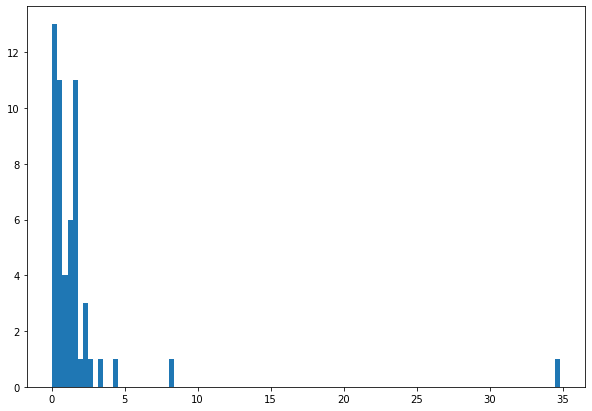

In [176]:
# Portfolio weights

# Figure Size
fig = plt.figure(figsize =(10, 7))
 
plt.hist(portfolio_df.pct_of_total,  bins=100)
plt.show() 

<AxesSubplot:xlabel='pct_of_total'>

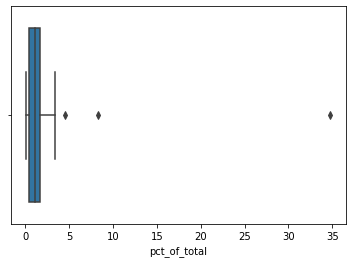

In [177]:
#Boxplot
sb.boxplot(x = 'pct_of_total', data = portfolio_df, showfliers = True)

### Get Stock Names

In [178]:
stock_names = [degiro.product_info(x) for x in portfolio_df['id'].values]
stock_names_df = pd.DataFrame(stock_names)

In [179]:
stock_names_df = stock_names_df[['id','name','symbol']]
stock_names_df.head()

,id,name,symbol
0,18343191,Goodrx Holdings Inc,GDRX
1,19790636,FIELD TRIP HEALTH LTD. - COMMON SHARES,FTRP
2,18333971,Palantir Technologies Inc,PLTR
3,19433248,FLORA GROWTH CORP. - COMMON STOCK,FLGC
4,16204538,Douyu International Holdings Ltd,DOYU


### Merge Portfolio and Stock Names

In [180]:
portfolio_stock_df = portfolio_df.merge(stock_names_df, how='left', on='id')

In [249]:
portfolio_stock_df.head(10)

,id,positionType,size,price,value,breakEvenPrice,pct_of_total,name,symbol
0,18343191,PRODUCT,1,39,34,37,0,Goodrx Holdings Inc,GDRX
1,19790636,PRODUCT,20,3,50,5,0,FIELD TRIP HEALTH LTD. - COMMON SHARES,FTRP
2,18333971,PRODUCT,1,19,17,28,0,Palantir Technologies Inc,PLTR
3,19433248,PRODUCT,10,2,19,4,0,FLORA GROWTH CORP. - COMMON STOCK,FLGC
4,16204538,PRODUCT,401,2,835,5,8,Douyu International Holdings Ltd,DOYU
5,1158412,PRODUCT,1,47,41,44,0,New York Times Co,NYT
6,1143347,PRODUCT,1,63,56,62,1,II-VI Inc,IIVI
7,18883077,PRODUCT,6,19,100,24,1,Poshmark Inc,POSH
8,1138996,PRODUCT,1,77,68,72,1,Descartes Systems Group (The),DSGX
9,17936164,PRODUCT,6,45,237,124,2,Lemonade Inc,LMND


### Web Scraping Yahoo Finance

https://finance.yahoo.com/quote/GDRX?p=GDRX

In [301]:
msft = yf.Ticker("MSFT")

# get stock info
test = msft.info

In [311]:
test

{'zip': '98052-6399',
 'sector': 'Technology',
 'fullTimeEmployees': 181000,
 'longBusinessSummary': 'Microsoft Corporation develops, licenses, and supports software, services, devices, and solutions worldwide. Its Productivity and Business Processes segment offers Office, Exchange, SharePoint, Microsoft Teams, Office 365 Security and Compliance, and Skype for Business, as well as related Client Access Licenses (CAL); Skype, Outlook.com, OneDrive, and LinkedIn; and Dynamics 365, a set of cloud-based and on-premises business solutions for organizations and enterprise divisions. Its Intelligent Cloud segment licenses SQL, Windows Servers, Visual Studio, System Center, and related CALs; GitHub that provides a collaboration platform and code hosting service for developers; and Azure, a cloud platform. It also offers support services and Microsoft consulting services to assist customers in developing, deploying, and managing Microsoft server and desktop solutions; and training and certifica

In [328]:
df = pd.DataFrame(test.items()).T

In [329]:
df.rename(columns=df.iloc[0])

,zip,sector,fullTimeEmployees,longBusinessSummary,city,phone,state,country,companyOfficers,website,...,fiveYearAvgDividendYield,fiftyTwoWeekLow,bid,tradeable,dividendYield,bidSize,dayHigh,regularMarketPrice,preMarketPrice,logo_url
0,zip,sector,fullTimeEmployees,longBusinessSummary,city,phone,state,country,companyOfficers,website,...,fiveYearAvgDividendYield,fiftyTwoWeekLow,bid,tradeable,dividendYield,bidSize,dayHigh,regularMarketPrice,preMarketPrice,logo_url
1,98052-6399,Technology,181000,"Microsoft Corporation develops, licenses, and ...",Redmond,425 882 8080,WA,United States,[],https://www.microsoft.com,...,1,209,335,False,0,1800,336,335,332,https://logo.clearbit.com/microsoft.com


____________________

In [258]:
stock_symbol_list = portfolio_stock_df.symbol.to_list()
#list = ['PLTR', 'POSH', 'LMND']
#list

In [264]:
#stock_symbol_list = portfolio_stock_df.symbol.to_list()
sector =[]
for item in stock_symbol_list:
    temp_var = item + '/' 
    url='https://finance.yahoo.com/quote/{0}'.format(temp_var)
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    sector.append(item)
    for entry in soup.find_all('span', {'class':'Fw(600)'}):
        if len(entry.text) >= 2 and entry.text != 'Morningstar' and entry.text != 'Argus Research':
            sector.append(entry.text)
sector

['GDRX',
 'Healthcare',
 'Health Information Services',
 '450',
 'FTRP',
 'PLTR',
 'Technology',
 'Software—Infrastructure',
 '2,733',
 'FLGC',
 'Healthcare',
 'Drug Manufacturers—Specialty & Generic',
 'DOYU',
 'Communication Services',
 'Internet Content & Information',
 '1,877',
 'NYT',
 'IIVI',
 'Technology',
 'Scientific & Technical Instruments',
 '22,961',
 'POSH',
 'Consumer Cyclical',
 'Internet Retail',
 '558',
 'DSGX',
 'LMND',
 'Financial Services',
 'Insurance—Property & Casualty',
 '567',
 'SPCE',
 'Industrials',
 'Aerospace & Defense',
 '823',
 'NVTA',
 'Healthcare',
 'Diagnostics & Research',
 '2,900',
 'JD',
 'Consumer Cyclical',
 'Internet Retail',
 '314,906',
 'ATVI',
 'Communication Services',
 'Electronic Gaming & Multimedia',
 '9,500',
 'BIDU',
 'Communication Services',
 'Internet Content & Information',
 '41,000',
 'FSLY',
 'Technology',
 'Software—Application',
 '992',
 'PINS',
 'Communication Services',
 'Internet Content & Information',
 '3,112',
 'PERI',
 'Co

In [266]:
len(sector)

188

In [267]:
len(stock_symbol_list), len(stock_symbol_list)*4

(54, 216)

In [251]:
#stock_symbol_list = portfolio_stock_df.symbol.to_list()
sector =[]
for item in list:
    temp_var = item + '/' 
    url='https://finance.yahoo.com/quote/{0}'.format(temp_var)
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    for entry in soup.find_all('p', {'class':'D(ib) Va(t)'}):
        if len(entry.text)>3 and entry.text != 'Morningstar':
            sector.append(entry.text)
sector

['Sector(s):\xa0TechnologyIndustry:\xa0Software—InfrastructureFull Time Employees:\xa02,733',
 'Sector(s):\xa0Consumer CyclicalIndustry:\xa0Internet RetailFull Time Employees:\xa0558']

In [ ]:
<p class="D(ib) Va(t)" data-reactid="20"><span data-reactid="21">Sector(s)</span><!-- react-text: 22 -->:&nbsp;<!-- /react-text --><span class="Fw(600)" data-reactid="23">Healthcare</span><br data-reactid="24"><span data-reactid="25">Industry</span><!-- react-text: 26 -->:&nbsp;<!-- /react-text --><span class="Fw(600)" data-reactid="27">Drug Manufacturers—Specialty &amp; Generic</span><br data-reactid="28"><span data-reactid="29">Full Time Employees</span><!-- react-text: 30 -->:&nbsp;<!-- /react-text --><span class="Fw(600)" data-reactid="31"></span></p>
<span class="Fw(600)" data-reactid="23">Healthcare</span>

In [233]:
sector

['Argus Research',
 'Healthcare',
 'Diagnostics & Research',
 '17,000',
 'Utilities',
 'Utilities—Regulated Electric',
 '17,300']

In [183]:
soup = BeautifulSoup(response.text, 'html.parser')
print(soup.title)

<title>Palantir Technologies Inc. (PLTR) Stock Price, News, Quote &amp; History - Yahoo Finance</title>


In [186]:
for entry in soup.find_all('span', {'class':'Fw(600)'}):
    if len(entry.text)>3 and entry.text != 'Morningstar':
        sector.append(entry.text)
    

In [187]:
sector

['Technology', 'Software—Infrastructure', '2,733']

In [133]:
sector[0]

'Morningstar'

### Portfolio Analysis - Unrealized Gains

##### Ideas: 
1. Industry
2. IPO 
3. Last 12 months return 
4. ...

In [17]:
portfolio_stock_df['unrealized_gains'] = round((portfolio_stock_df['price']-portfolio_stock_df['breakEvenPrice'])*portfolio_stock_df['size'],2)

In [166]:
#Total Value of Portfolio
round(portfolio_stock_df['value'].sum(),2)

10006.14

In [167]:
#Total Value of Unrealized Gains
round(portfolio_stock_df['unrealized_gains'].sum(),2)

-5205.9

In [21]:
#Assign Quantiles to the Stocks % of total
quantiles = pd.qcut(portfolio_stock_df['pct_of_total'], 4, labels=False)
portfolio_stock_df = portfolio_stock_df.assign(quantile=quantiles.values)
portfolio_stock_df.head()

,id,positionType,size,price,value,breakEvenPrice,pct_of_total,name,symbol,unrealized_gains,quantile
0,18343191,PRODUCT,1.0,38.42,33.974806,36.710000,0.34,Goodrx Holdings Inc,GDRX,1.71,0
1,19790636,PRODUCT,20.0,3.15,55.710900,5.210000,0.56,FIELD TRIP HEALTH LTD. - COMMON SHARES,FTRP,-41.20,1
2,18333971,PRODUCT,1.0,18.98,16.784014,28.311741,0.17,Palantir Technologies Inc,PLTR,-9.33,0
3,19433248,PRODUCT,10.0,1.94,17.155420,3.892857,0.17,FLORA GROWTH CORP. - COMMON STOCK,FLGC,-19.53,0
4,16204538,PRODUCT,401.0,2.27,804.951761,5.211147,8.04,Douyu International Holdings Ltd,DOYU,-1179.40,3


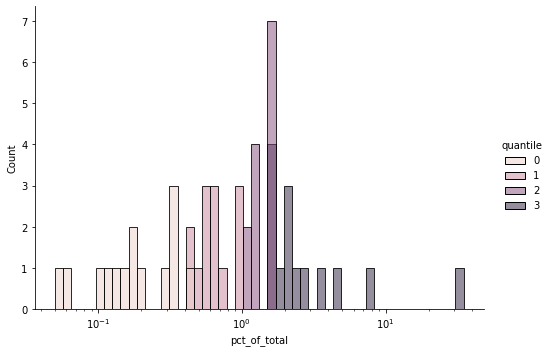

In [22]:
#Overlayed Distribution by quantile
sb.displot(
  data=portfolio_stock_df,
  x="pct_of_total",
  hue="quantile",
  kind="hist",
  aspect=1.4,
  log_scale=10,
  bins=50
)

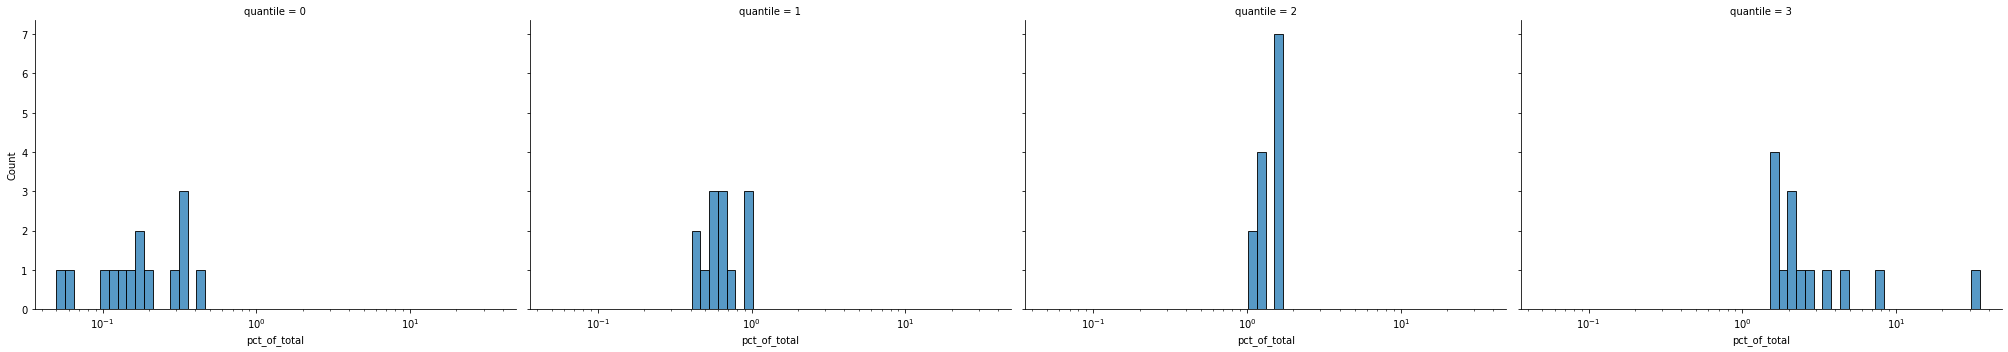

In [23]:
#Distributions by quantile
sb.displot(
  data=portfolio_stock_df,
  x="pct_of_total",
  col="quantile",
  kind="hist",
  aspect=1.4,
  log_scale=10,
  bins=50
)

### Transactions

In [24]:
transactions = degiro.transactions(datetime(2018, 1, 1), datetime.now())

In [25]:
transactions_df = pd.DataFrame(transactions)

In [26]:
transactions_df.describe()

,id,productId,price,quantity,total,orderTypeId,fxRate,totalInBaseCurrency,feeInBaseCurrency,totalPlusFeeInBaseCurrency,transactionTypeId
count,8.760000e+02,8.760000e+02,876.000000,876.000000,876.000000,870.000000,876.000000,876.000000,852.000000,876.000000,876.000000
mean,2.125192e+08,1.178274e+07,112.263895,1.089041,11.861818,1.806897,1.219161,6.367550,-0.761185,5.627219,0.719178
std,4.353589e+07,6.091382e+06,173.450285,1205.582333,1503.419313,0.591033,1.176719,1227.270217,1.013625,1227.244843,8.668427
min,1.534398e+08,2.554290e+05,0.020000,-30000.000000,-8075.200000,0.000000,0.000000,-6598.463588,-9.070000,-6599.223588,0.000000
25%,1.658811e+08,5.586795e+06,27.525000,-5.000000,-587.575000,2.000000,1.108708,-511.433991,-0.592500,-511.943991,0.000000
50%,2.074266e+08,1.465250e+07,65.955000,1.000000,-103.385000,2.000000,1.131118,-87.057732,-0.530000,-87.557732,0.000000
75%,2.388252e+08,1.608294e+07,146.092500,10.000000,480.900000,2.000000,1.180780,407.109835,-0.510000,406.669835,0.000000
max,3.213756e+08,1.981116e+07,2293.590000,15000.000000,11467.000000,2.000000,10.767056,9407.389091,-0.010000,9406.559091,108.000000


In [27]:
transactions_df.head()

,id,productId,date,buysell,price,quantity,total,orderTypeId,counterParty,transfered,fxRate,totalInBaseCurrency,feeInBaseCurrency,totalPlusFeeInBaseCurrency,transactionTypeId,tradingVenue
0,153439824,13433777,2019-04-04T15:30:00+02:00,B,21.98,15,-329.70,2.0,MK,False,1.120920,-294.135583,-0.55,-294.685583,0,XNYS
1,153514251,1156277,2019-04-04T17:34:27+02:00,B,84.76,5,-423.80,2.0,MK,False,1.122221,-377.651951,-0.52,-378.171951,0,IEXG
2,153946118,1135199,2019-04-10T15:39:10+02:00,B,178.82,1,-178.82,2.0,MK,False,1.124323,-159.050799,-0.50,-159.550799,0,EDGA
3,153946119,1135199,2019-04-10T15:39:10+02:00,B,178.79,2,-357.58,2.0,MK,False,1.124323,-318.051624,-0.01,-318.061624,0,XNAS
4,154053075,1140987,2019-04-11T15:33:43+02:00,B,90.55,6,-543.30,2.0,MK,False,1.126525,-482.287253,-0.52,-482.807253,0,BATS


### Transactions Analysis

[]


In [ ]:
import degiroapi
from degiroapi.product import Product
from degiroapi.order import Order
from degiroapi.utils import pretty_json

import pandas as pd
import numpy as np

from datetime import datetime, timedelta

# login
degiro = degiroapi.DeGiro()
degiro.login("RobinHocepied", "Jeancharles146124%")

  
# getting realtime and historical data from a stock
products = degiro.search_products('PINS')
high=[]
nb = []


for x in range(2):
        realprice = degiro.real_time_price(Product(products[0]).id, degiroapi.Interval.Type.Max)  
        rp = realprice[0]['data']['lastPrice']
        print(high)
    
        #time.sleep(60)
        realprice1 = degiro.real_time_price(Product(products[0]).id, degiroapi.Interval.Type.Max)  
        rp1 = realprice1[0]['data']['lastPrice']
        if rp1 > rp:
            rp3 = 0.97*rp1
            high.append(rp1*0.97)
            nb.append(1)
            degiro.buyorder(Order.Type.LIMIT, Product(products[0]).id, 3, 1, round(rp3,2))
            if len(nb) == 0: 
                break
            break
        break
            
        print(high)
        print(nb)
       
